# Credit Card Fraud Detection (part2)
The objective is to identify fraudulent credit card transactions (492 instances) among legitimate transactions (284315 instances). In the previous notebook we dealt with the imbalanced class problem by assigning greater weight to the fraudulent cases so that the classifiers penalize fraudulent transactions misclassified as legitimate more as compared to legitimate transactions misclassified as fraud. We will utilize over/under sampling methods in this notebook instead.

Please refer to the previous notebook for more information about the dataset.

## Step 1: Loading libraries to be used in the modeling and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('numpy version: ',np.__version__)
print('pandas version: ',pd.__version__)
print('seaborn version: ',sns.__version__)

numpy version:  1.18.1
pandas version:  1.0.0
seaborn version:  0.10.0


In [2]:
#loading the data from the csv file downloaded from Kaggle

data = pd.read_csv('datasets/credit-card-fraud.csv', header='infer')

X = data.iloc[:, 0:30]
y = data.loc[:, 'Class']

## Step 2: Splitting the data into training and test sets

In [3]:
#setting the random seed for reproducibility
random_seed = 2020

In [4]:
# I am setting 33.3% data aside for the test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, stratify=y, random_state=random_seed)

## Step 3: Reviewing the results of the previous notebook
The following models gave us the best results with respect to average precision in the previous notebook:
* ETsC -- Extra Trees Classifier witn n_estimators=200
* RFC -- Random Forest Classifier with n_estimators=150
* LGBM -- LGBMClassifier with n_estimators=150 and learning_rate=0.2

Here we will reproduce these results and precision-recall curve for all models to establish a baseline for comparing subsequent models.

In [5]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

In [6]:
ETsC = ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=random_seed, 
                              n_jobs=-1)
ETsC.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

In [7]:
RFC = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=random_seed,
                             n_jobs=-1)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)

In [8]:
LGBM = lgb.LGBMClassifier(class_weight='balanced', random_state=random_seed, n_estimators=150, 
                          learning_rate=0.2, n_jobs=-1)
LGBM.fit(X_train, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.2,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

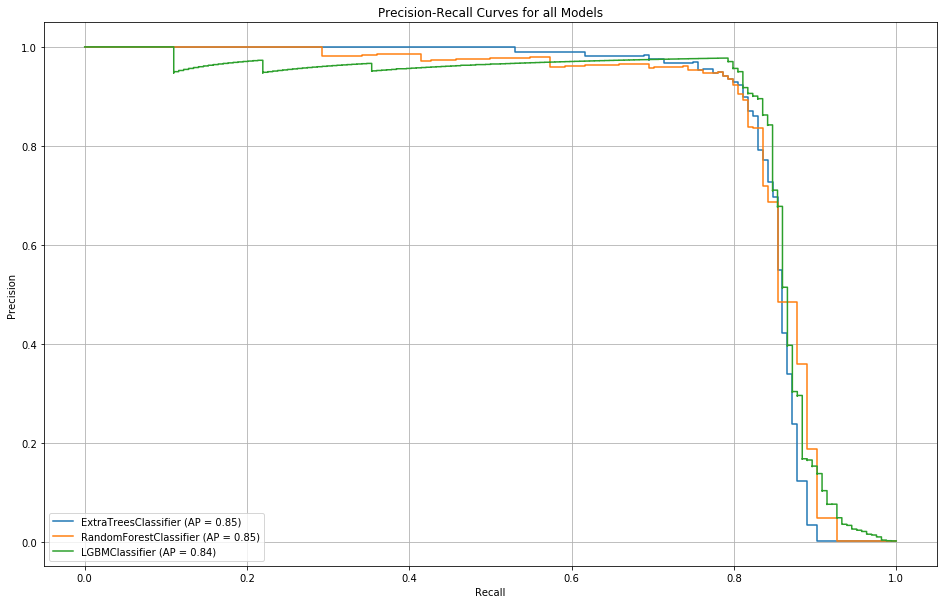

In [9]:
disp_ETsC = plot_precision_recall_curve(ETsC, X_test, y_test)
disp_RFC = plot_precision_recall_curve(RFC, X_test, y_test, ax=disp_ETsC.ax_)
disp_LGBM = plot_precision_recall_curve(LGBM, X_test, y_test, ax=disp_ETsC.ax_)
disp_ETsC.ax_.set_title('Precision-Recall Curves for all Models')
disp_ETsC.figure_.set_size_inches(16, 10)
plt.grid()
plt.show()

In [10]:
print('ETsC Average Precision = ', np.round(disp_ETsC.average_precision, 5))
print('RFC Average Precision = ', np.round(disp_RFC.average_precision, 5))
print('LGBM Average Precision = ', np.round(disp_LGBM.average_precision, 5))

ETsC Average Precision =  0.84951
RFC Average Precision =  0.84819
LGBM Average Precision =  0.84353


## Step 4: Undersampling
Now we will use various undersampling techniques with ETsC, RFC, and LGBM with default settings.

In [11]:
from imblearn.under_sampling import (EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NearMiss,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection,
                                     RandomUnderSampler,
                                     TomekLinks)
undersamplers = [
    ('enn', EditedNearestNeighbours()),
    ('renn', RepeatedEditedNearestNeighbours()),
    ('aknn', AllKNN()),
    ('nrms', NearMiss()),
    ('ncr', NeighbourhoodCleaningRule()),
    ('oss', OneSidedSelection(random_state=random_seed)),
    ('rus', RandomUnderSampler(random_state=random_seed)),
    ('tmk', TomekLinks())
]

Using TensorFlow backend.


#### Warning:
We originally had 'Condensed Nearest Neighbour' and 'Instance Hardness Threshold' in the undersampler list; however, they are taken out due to the fact that it took considerable time to train without remarkable results.

In [12]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

cv = 5
scoring = 'average_precision'

### Extra Trees Classifier with Undersampling

In [13]:
cv_results_etsc = {}

for name, us in undersamplers:
    model_pip = Pipeline([
        (name, us),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_etsc[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.6s remaining:   53.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [14]:
results_df_etsc = pd.DataFrame(cv_results_etsc, index=range(1, cv+1))

In [15]:
results_df_etsc.mean(axis='index').sort_values()

rus     0.734535
nrms    0.737279
renn    0.841533
aknn    0.841813
oss     0.842150
tmk     0.842398
enn     0.843145
ncr     0.844481
dtype: float64

In [16]:
results_df_etsc.std(axis='index')

enn     0.016680
renn    0.018222
aknn    0.018202
nrms    0.039806
ncr     0.018324
oss     0.018340
rus     0.037462
tmk     0.017504
dtype: float64

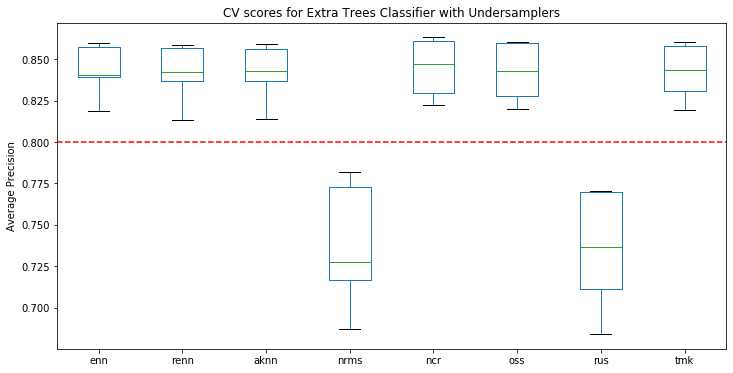

In [17]:
results_df_etsc.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for Extra Trees Classifier with Undersamplers')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

### Random Forest Classifier with Undersampling

In [18]:
cv_results_rfc = {}

for name, us in undersamplers:
    model_pip = Pipeline([
        (name, us),
        ('rfc', RandomForestClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_rfc[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [19]:
results_df_rfc = pd.DataFrame(cv_results_rfc, index=range(1, cv+1))

In [20]:
results_df_rfc.mean(axis='index').sort_values()

nrms    0.736033
rus     0.742984
oss     0.833217
tmk     0.835633
renn    0.835924
ncr     0.836188
enn     0.836364
aknn    0.838108
dtype: float64

In [21]:
results_df_rfc.std(axis='index')

enn     0.012665
renn    0.013345
aknn    0.018080
nrms    0.035183
ncr     0.013430
oss     0.017559
rus     0.041908
tmk     0.014099
dtype: float64

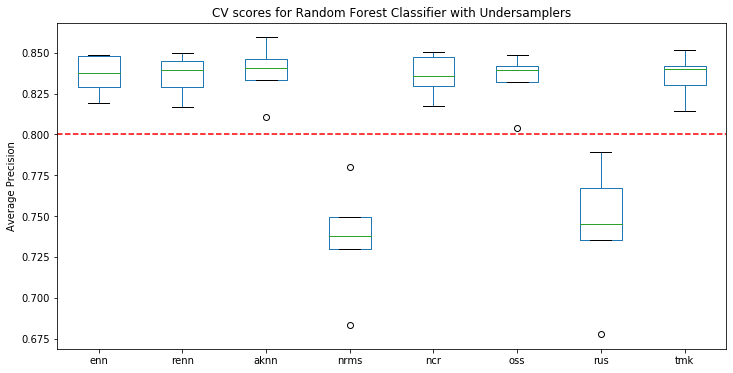

In [22]:
results_df_rfc.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for Random Forest Classifier with Undersamplers')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

### LGBM Classifier with Undersampling

In [23]:
cv_results_lgbm = {}

for name, us in undersamplers:
    model_pip = Pipeline([
        (name, us),
        ('lgbm', lgb.LGBMClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_lgbm[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.9s remaining:   38.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [24]:
results_df_lgbm = pd.DataFrame(cv_results_lgbm, index=range(1, cv+1))

In [25]:
results_df_lgbm.mean(axis='index').sort_values()

ncr     0.095025
enn     0.121612
renn    0.131549
aknn    0.174218
oss     0.174278
tmk     0.189949
nrms    0.629813
rus     0.682396
dtype: float64

In [26]:
results_df_lgbm.std(axis='index')

enn     0.115590
renn    0.093273
aknn    0.125663
nrms    0.125238
ncr     0.124298
oss     0.074071
rus     0.068642
tmk     0.133578
dtype: float64

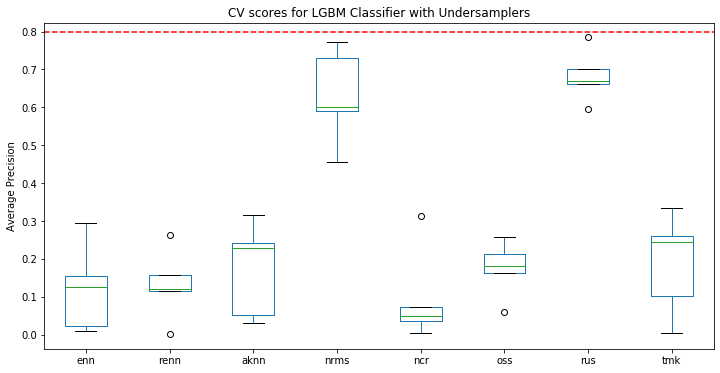

In [27]:
results_df_lgbm.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for LGBM Classifier with Undersamplers')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

## Step 5: Oversampling
Now we will use various oversampling and combination techniques with ETsC, RFC, and LGBM with default settings.

In [28]:
from imblearn.over_sampling import (ADASYN,
                                    BorderlineSMOTE,
                                    RandomOverSampler,
                                    SMOTE,
                                    SVMSMOTE)
from imblearn.combine import SMOTEENN, SMOTETomek
oversamplers = [
    ('ada', ADASYN(random_state=random_seed)),
    ('bls', BorderlineSMOTE(random_state=random_seed)),
    ('ros', RandomOverSampler(random_state=random_seed)),
    ('smt', SMOTE(random_state=random_seed)),
    ('svsm', SVMSMOTE(random_state=random_seed)),
    ('smtenn', SMOTEENN(random_state=random_seed)),
    ('smttmk', SMOTETomek(random_state=random_seed))
]

### Extra Trees Classifier with Oversampling

In [29]:
cv_results_etsc_o = {}

for name, os in oversamplers:
    model_pip = Pipeline([
        (name, os),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_etsc_o[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   52.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   52.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [30]:
results_df_etsc_o = pd.DataFrame(cv_results_etsc_o, index=range(1, cv+1))

In [31]:
results_df_etsc_o.mean(axis='index').sort_values()

smtenn    0.835111
smt       0.842020
svsm      0.845015
smttmk    0.845444
ros       0.845491
ada       0.845796
bls       0.846461
dtype: float64

In [32]:
results_df_etsc_o.std(axis='index')

ada       0.025109
bls       0.015611
ros       0.021334
smt       0.021908
svsm      0.016804
smtenn    0.020804
smttmk    0.025634
dtype: float64

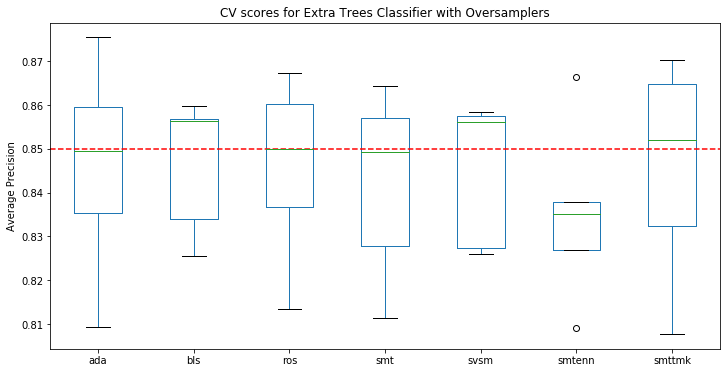

In [33]:
results_df_etsc_o.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for Extra Trees Classifier with Oversamplers')
plt.axhline(y=0.85, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

### Random Forest Classifier with Oversampling

In [34]:
cv_results_rfc_o = {}

for name, os in oversamplers:
    model_pip = Pipeline([
        (name, os),
        ('rfc', RandomForestClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_rfc_o[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [35]:
results_df_rfc_o = pd.DataFrame(cv_results_rfc_o, index=range(1, cv+1))

In [36]:
results_df_rfc_o.mean(axis='index').sort_values()

smttmk    0.832530
ada       0.833601
bls       0.835362
smtenn    0.837292
svsm      0.837391
smt       0.838485
ros       0.843578
dtype: float64

In [37]:
results_df_rfc_o.std(axis='index')

ada       0.023046
bls       0.018270
ros       0.020801
smt       0.022094
svsm      0.012061
smtenn    0.020160
smttmk    0.019193
dtype: float64

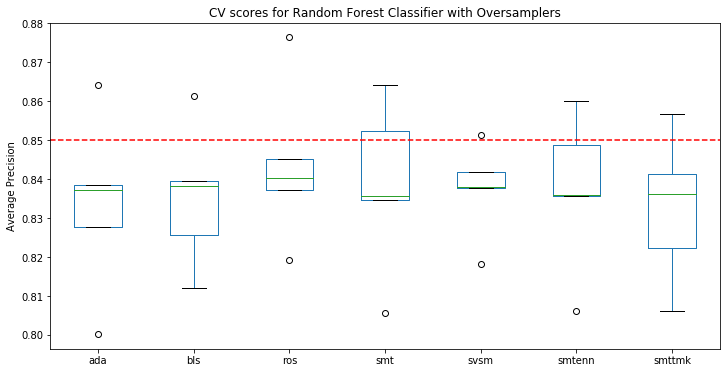

In [38]:
results_df_rfc_o.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for Random Forest Classifier with Oversamplers')
plt.axhline(y=0.85, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

### LGBM Classifier with Oversampling

In [39]:
cv_results_lgbm_o = {}

for name, os in oversamplers:
    model_pip = Pipeline([
        (name, os),
        ('lgbm', lgb.LGBMClassifier(random_state=random_seed))
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_lgbm_o[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.1s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [40]:
results_df_lgbm_o = pd.DataFrame(cv_results_lgbm_o, index=range(1, cv+1))

In [41]:
results_df_lgbm_o.mean(axis='index').sort_values()

smt       0.773090
smttmk    0.788245
ada       0.795778
smtenn    0.798648
bls       0.829631
ros       0.836730
svsm      0.842851
dtype: float64

In [42]:
results_df_lgbm_o.std(axis='index')

ada       0.060580
bls       0.020305
ros       0.028980
smt       0.031866
svsm      0.012490
smtenn    0.053073
smttmk    0.059774
dtype: float64

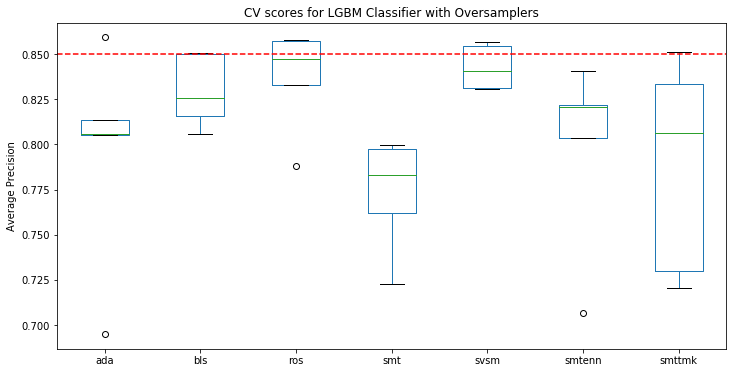

In [43]:
results_df_lgbm_o.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for LGBM Classifier with Oversamplers')
plt.axhline(y=0.85, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

## Step 6: Fine tuning of promising models
Now we will fine tune (finding optimal hyperparameters) for the top four models using 5-fold cross validation with respect to 'average precision':
1. Extra Trees Classifier with Border Line SMOTE (AP = 0.846461)
2. Extra Trees Classifier with ADASYN (AP = 0.845796)
3. Extra Trees Classifier with Random Over Sampler (AP = 0.845491)
4. Extra Trees Classifier with Neighbourhood Cleaning Rule (AP = 0.844481)

In [44]:
from sklearn.model_selection import GridSearchCV

### Extra Trees Classifier with Border Line SMOTE

In [45]:
n_estimators = [75, 100, 150, 200]   #default=100, bias increases as it decreases
k_neighbors = [3, 5, 7] #default=5
m_neighbors = [8, 10, 12] #default=10
kind = ['borderline-1', 'borderline-2'] #default='borderline-1'

par_grid_bls = dict(etsc__n_estimators=n_estimators, bls__k_neighbors=k_neighbors, 
                    bls__m_neighbors=m_neighbors, bls__kind=kind)

model_pip = Pipeline([
        ('bls', BorderlineSMOTE(random_state=random_seed)),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])

grid_bls = GridSearchCV(estimator=model_pip, param_grid=par_grid_bls, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_bls = grid_bls.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 82.2min finished


In [46]:
grid_result_bls.best_params_

{'bls__k_neighbors': 7,
 'bls__kind': 'borderline-1',
 'bls__m_neighbors': 10,
 'etsc__n_estimators': 150}

In [47]:
grid_result_bls.best_score_

0.8530669366143346

In [48]:
pd.DataFrame(grid_result_bls.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
54,"{'bls__k_neighbors': 7, 'bls__kind': 'borderli...",0.853067,0.010292,1
43,"{'bls__k_neighbors': 5, 'bls__kind': 'borderli...",0.852627,0.011723,2
67,"{'bls__k_neighbors': 7, 'bls__kind': 'borderli...",0.852576,0.009133,3
39,"{'bls__k_neighbors': 5, 'bls__kind': 'borderli...",0.852188,0.011488,4
55,"{'bls__k_neighbors': 7, 'bls__kind': 'borderli...",0.852162,0.011592,5
42,"{'bls__k_neighbors': 5, 'bls__kind': 'borderli...",0.851685,0.010191,6
71,"{'bls__k_neighbors': 7, 'bls__kind': 'borderli...",0.851673,0.012416,7


#### The best model is Extra Trees Classifier (n_estimators=150) oversampled with Border Line SMOTE (k_neighbors=7)

### Extra Trees Classifier with ADASYN

In [49]:
n_estimators = [75, 100, 150, 200]   #default=100, bias increases as it decreases
n_neighbors = [2, 3, 4, 5, 6, 7] #default=5

par_grid_ada = dict(etsc__n_estimators=n_estimators, ada__n_neighbors=n_neighbors)
                    
model_pip = Pipeline([
        ('ada', ADASYN(random_state=random_seed)),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])

grid_ada = GridSearchCV(estimator=model_pip, param_grid=par_grid_ada, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_ada = grid_ada.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 27.5min finished


In [50]:
grid_result_ada.best_params_

{'ada__n_neighbors': 7, 'etsc__n_estimators': 200}

In [51]:
grid_result_ada.best_score_

0.8532866228850594

In [52]:
pd.DataFrame(grid_result_ada.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
23,"{'ada__n_neighbors': 7, 'etsc__n_estimators': ...",0.853287,0.011428,1
18,"{'ada__n_neighbors': 6, 'etsc__n_estimators': ...",0.852660,0.015241,2
17,"{'ada__n_neighbors': 6, 'etsc__n_estimators': ...",0.852536,0.017110,3
19,"{'ada__n_neighbors': 6, 'etsc__n_estimators': ...",0.852338,0.015660,4
22,"{'ada__n_neighbors': 7, 'etsc__n_estimators': ...",0.850984,0.012799,5
15,"{'ada__n_neighbors': 5, 'etsc__n_estimators': ...",0.850597,0.019724,6
16,"{'ada__n_neighbors': 6, 'etsc__n_estimators': 75}",0.850391,0.021329,7


#### The best model is Extra Trees Classifier (n_estimators=200) oversampled with ADASYN (n_neighbors=7)

### Extra Trees Classifier with Random Over Sampler

In [53]:
n_estimators = [75, 100, 150, 200]   #default=100, bias increases as it decreases

par_grid_ros = dict(etsc__n_estimators=n_estimators)
                    
model_pip = Pipeline([
        ('ros', RandomOverSampler(random_state=random_seed)),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])

grid_ros = GridSearchCV(estimator=model_pip, param_grid=par_grid_ros, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_ros = grid_ros.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  4.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.0min finished


In [54]:
grid_result_ros.best_params_

{'etsc__n_estimators': 200}

In [55]:
grid_result_ros.best_score_

0.8459686697670648

In [56]:
pd.DataFrame(grid_result_ros.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
3,{'etsc__n_estimators': 200},0.845969,0.019069,1
1,{'etsc__n_estimators': 100},0.845491,0.019082,2
2,{'etsc__n_estimators': 150},0.845420,0.017945,3
0,{'etsc__n_estimators': 75},0.843367,0.019299,4


#### The best model is Extra Trees Classifier (n_estimators=150) -picked due to lower variance- oversampled with Random Over Sampler

### Extra Trees Classifier with Neighbourhood Cleaning Rule

In [57]:
n_estimators = [75, 100, 150, 200]   #default=100, bias increases as it decreases
n_neighbors = [2, 3, 4, 5]  #default=3
threshold_cleaning = [0.45, 0.50, 0.55]  #default=0.5

par_grid_ncr = dict(etsc__n_estimators=n_estimators, ncr__n_neighbors=n_neighbors, 
                    ncr__threshold_cleaning=threshold_cleaning)
                    
model_pip = Pipeline([
        ('ncr', NeighbourhoodCleaningRule()),
        ('etsc', ExtraTreesClassifier(random_state=random_seed))
    ])

grid_ncr = GridSearchCV(estimator=model_pip, param_grid=par_grid_ncr, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_ncr = grid_ncr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 37.7min finished


In [58]:
grid_result_ncr.best_params_

{'etsc__n_estimators': 200,
 'ncr__n_neighbors': 3,
 'ncr__threshold_cleaning': 0.45}

In [59]:
grid_result_ncr.best_score_

0.8478271760231489

In [60]:
pd.DataFrame(grid_result_ncr.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
41,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847827,0.016132,1
40,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847827,0.016132,1
39,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847827,0.016132,1
38,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847186,0.015690,4
36,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847186,0.015690,4
37,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.847186,0.015690,4
47,"{'etsc__n_estimators': 200, 'ncr__n_neighbors'...",0.846991,0.019938,7


#### The best model is Extra Trees Classifier (n_estimators=200) undersampled with Neighbourhood Cleaning Rule (threshold_cleaning=0.45)

## Step 7: Evaluation of top models on the test set

#### Extra Trees Classifier (n_estimators=150) oversampled with Border Line SMOTE (k_neighbors=7)

In [61]:
bls = BorderlineSMOTE(k_neighbors=7, random_state=random_seed, n_jobs=-1)
X_train_bls, y_train_bls = bls.fit_sample(X_train, y_train)

etsc_bls = ExtraTreesClassifier(n_estimators=150, random_state=random_seed, n_jobs=-1)
etsc_bls.fit(X_train_bls, y_train_bls)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

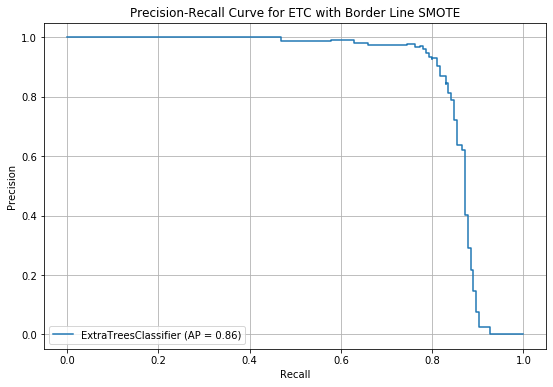

In [62]:
disp_bls = plot_precision_recall_curve(etsc_bls, X_test, y_test)
disp_bls.ax_.set_title('Precision-Recall Curve for ETC with Border Line SMOTE')
disp_bls.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

In [63]:
print('ETC with Border Line SMOTE Average Precision on the Test Set = ', np.round(disp_bls.average_precision, 5))

ETC with Border Line SMOTE Average Precision on the Test Set =  0.85844


### Extra Trees Classifier (n_estimators=200) oversampled with ADASYN (n_neighbors=7)

In [64]:
ada = ADASYN(n_neighbors=7, random_state=random_seed, n_jobs=-1)
X_train_ada, y_train_ada = ada.fit_sample(X_train, y_train)

etsc_ada = ExtraTreesClassifier(n_estimators=200, random_state=random_seed, n_jobs=-1)
etsc_ada.fit(X_train_ada, y_train_ada)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

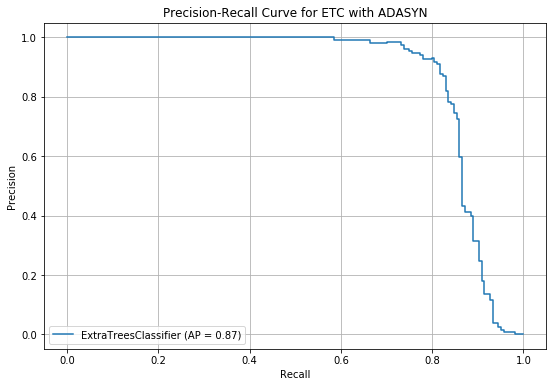

In [65]:
disp_ada = plot_precision_recall_curve(etsc_ada, X_test, y_test)
disp_ada.ax_.set_title('Precision-Recall Curve for ETC with ADASYN')
disp_ada.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

In [66]:
print('ETC with ADASYN Average Precision on the Test Set = ', np.round(disp_ada.average_precision, 5))

ETC with ADASYN Average Precision on the Test Set =  0.86789


### Extra Trees Classifier (n_estimators=150) oversampled with Random Over Sampler

In [67]:
ros = RandomOverSampler(random_state=random_seed)
X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)

etsc_ros = ExtraTreesClassifier(n_estimators=150, random_state=random_seed, n_jobs=-1)
etsc_ros.fit(X_train_ros, y_train_ros)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

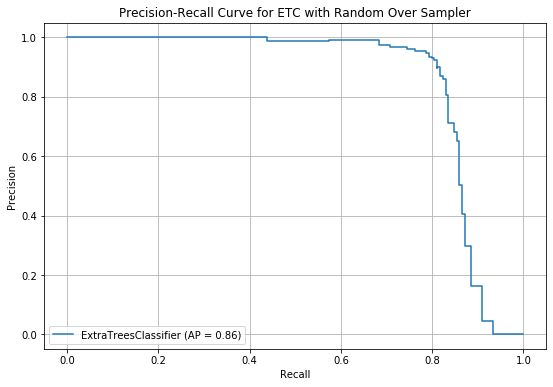

In [68]:
disp_ros = plot_precision_recall_curve(etsc_ros, X_test, y_test)
disp_ros.ax_.set_title('Precision-Recall Curve for ETC with Random Over Sampler')
disp_ros.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

In [69]:
print('ETC with Random Over Sampler Average Precision on the Test Set = ', np.round(disp_ros.average_precision, 5))

ETC with Random Over Sampler Average Precision on the Test Set =  0.85533


### Extra Trees Classifier (n_estimators=200) undersampled with Neighbourhood Cleaning Rule (threshold_cleaning=0.45)

In [70]:
ncr = NeighbourhoodCleaningRule(threshold_cleaning=0.45, n_jobs=-1)
X_train_ncr, y_train_ncr = ncr.fit_sample(X_train, y_train)

etsc_ncr = ExtraTreesClassifier(n_estimators=200, random_state=random_seed, n_jobs=-1)
etsc_ncr.fit(X_train_ncr, y_train_ncr)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

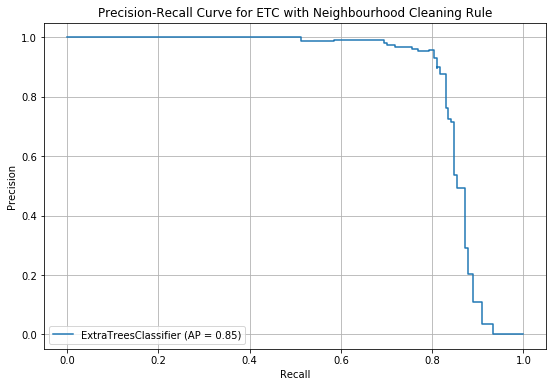

In [71]:
disp_ncr = plot_precision_recall_curve(etsc_ncr, X_test, y_test)
disp_ncr.ax_.set_title('Precision-Recall Curve for ETC with Neighbourhood Cleaning Rule')
disp_ncr.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

In [72]:
print('ETC with Neighbourhood Cleaning Rule Average Precision on the Test Set = ', np.round(disp_ncr.average_precision, 5))

ETC with Neighbourhood Cleaning Rule Average Precision on the Test Set =  0.85405


## Step 8: Conclusion
Based on the precision-recall curves below:
1. All four models performed similarly on the test set. If one model is better than any other along the precision-recall curve, it is only marginally so.
2. Extra Trees Classifier with Random Over Sampler is dominated by the trio of the remaining models; thus, it will be a safe bet to remove it from the lot.

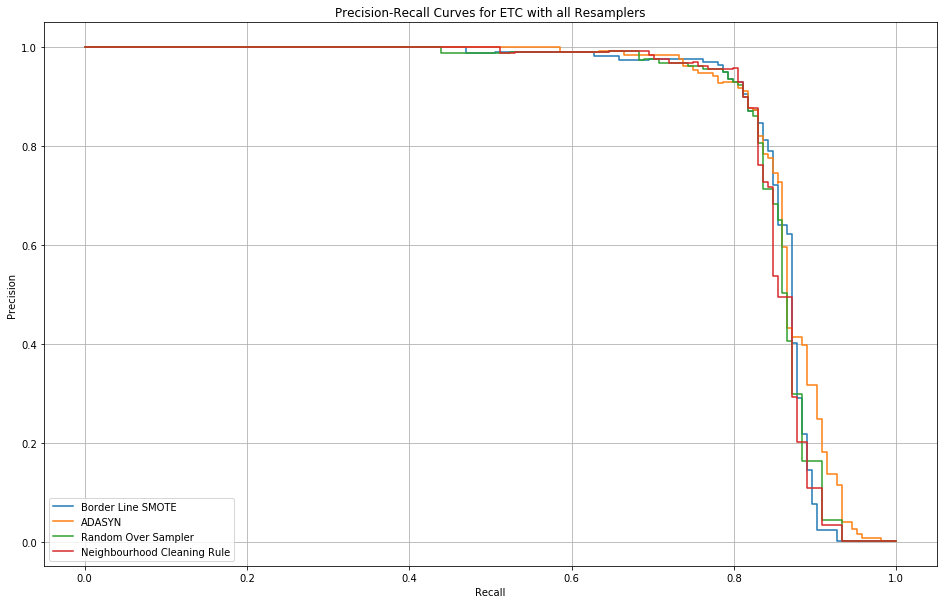

In [73]:
disp_bls.plot(label='Border Line SMOTE')
disp_ada.plot(label='ADASYN', ax=disp_bls.ax_)
disp_ros.plot(label='Random Over Sampler', ax=disp_bls.ax_)
disp_ncr.plot(label='Neighbourhood Cleaning Rule', ax=disp_bls.ax_)
disp_bls.figure_.set_size_inches(16, 10)
disp_bls.ax_.set_title('Precision-Recall Curves for ETC with all Resamplers')
plt.grid()
plt.show()

Now, we will compare Extra Trees Classifier with Border Line SMOTE, ADASYN, and Neighbourhood Cleaning Rule with Random Forest Classifier and LGBM Classifier from the previous notebook.

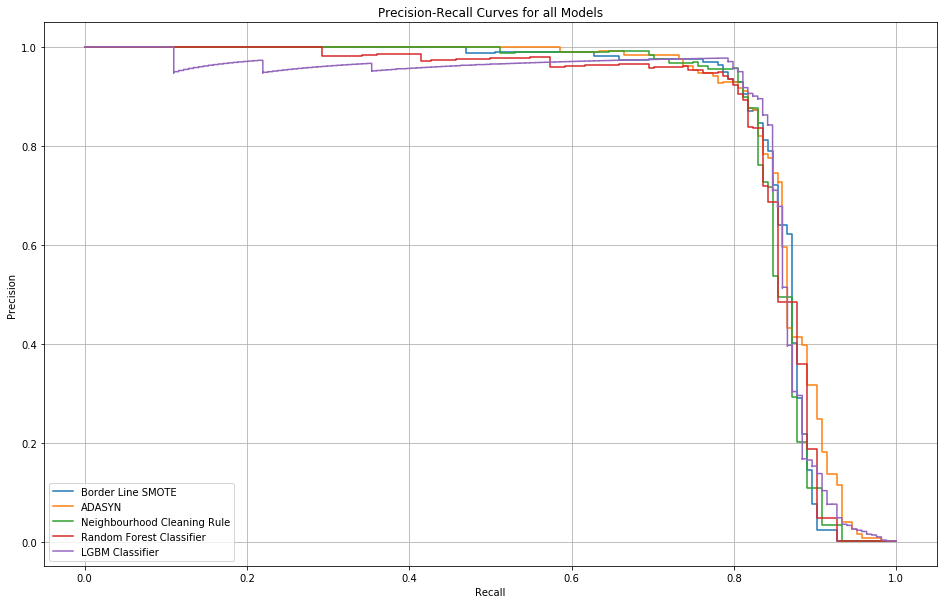

In [74]:
disp_bls.plot(label='Border Line SMOTE')
disp_ada.plot(label='ADASYN', ax=disp_bls.ax_)
disp_ncr.plot(label='Neighbourhood Cleaning Rule', ax=disp_bls.ax_)
disp_RFC.plot(label='Random Forest Classifier', ax=disp_bls.ax_)
disp_LGBM.plot(label='LGBM Classifier', ax=disp_bls.ax_)
disp_bls.figure_.set_size_inches(16, 10)
disp_bls.ax_.set_title('Precision-Recall Curves for all Models')
plt.grid()
plt.show()

LGBM Classifier and ETC with ADASYN together seem to dominate rest of the models along the precision-recall curve except at a very small stretch with a very small margin. Therefore, it seems reasonable to drop all the other models from the group. We will plot the precision-recall curve for these two below for sake of completeness.

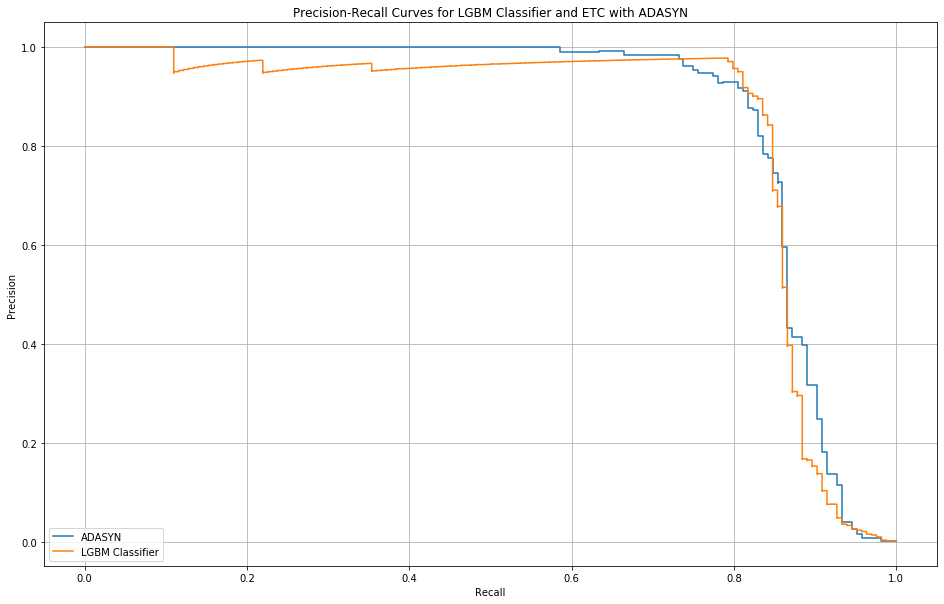

In [75]:
disp_ada.plot(label='ADASYN')
disp_LGBM.plot(label='LGBM Classifier', ax=disp_ada.ax_)
disp_ada.figure_.set_size_inches(16, 10)
disp_ada.ax_.set_title('Precision-Recall Curves for LGBM Classifier and ETC with ADASYN')
plt.grid()
plt.show()